**Предварительная работа:**

**1.** Подключение гугл-диска, на котором хранятся данные.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**2.** Установка модулей biopython и bedtools.

In [ ]:
!pip install biopython

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [ ]:
filename = '/content/drive/My Drive/bioinf/GSM3417036_TriplexDNASeq_plus_RNA_ligation.bed'

In [ ]:
!apt-get install bedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 2s (285 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...


In [ ]:
!pip install pybedtools

     |████████████████████████████████| 12.5MB 248kB/s 
     |████████████████████████████████| 10.0MB 10.9MB/s 
  Created wheel for pybedtools: filename=pybedtools-0.8.1-cp36-cp36m-linux_x86_64.whl size=13605423 sha256=1da899da4b9ca2ac94febf0231e04865f665f17ac5106799484ccc0582b896f7
  Stored in directory: /root/.cache/pip/wheels/6b/50/97/7d0e4f605d0d1578997f4bba3061869c2dee9f8cd29f626323
Successfully built pybedtools


**3.** Прочтение файла с сайтами формирования триплексов.

In [ ]:
from pybedtools import BedTool

In [ ]:
data = BedTool(filename)

In [ ]:
example = data[0]

In [ ]:
example.chrom

'chr1'

In [ ]:
example.start

629800

In [ ]:
example.end

630250

In [ ]:
example.strand

'-'

**4.** Прочтение файлов с последовательностью ДНК человеческого генома.

In [ ]:
names = ['chr' + str(i + 1) for i in range(22)]
names.append('chrX')
names.append('chrY')
names

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX',
 'chrY']

In [ ]:
from Bio import SeqIO
from Bio.Alphabet import generic_dna

chroms = {}

for name in names:
  chroms[name] = SeqIO.read('/content/drive/My Drive/bioinf/hg38/' + name + '.fa', 'fasta', generic_dna)

In [ ]:
chroms[example.chrom][example.start:example.end]

SeqRecord(seq=Seq('AGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAAT...TAA', DNAAlphabet()), id='chr1', name='chr1', description='chr1', dbxrefs=[])

**5.** Получение последовательности ДНК на заданном участке генома и перевод её в признаки для модели при помощи one-hot encoding.

In [ ]:
import math

input_len = 2000

In [ ]:
def get_subseq(record, subseq_len=input_len):
    left_add = 0
    right_add = 0
    if abs(record.end - record.start) > subseq_len:
        output = []
        start = record.start - (subseq_len // 2 * math.ceil((record.end - record.start) / (subseq_len // 2)) - (record.end - record.start)) // 2
        end = start + subseq_len
        while start <= record.end:
            if record.strand == '-':
                output.append(chroms[record.chrom][start:end].seq.reverse_complement())
            else:
                output.append(chroms[record.chrom][start:end].seq)
                
            start += subseq_len // 2
            end += subseq_len // 2
        return output
            
                

    left_add = (subseq_len - abs(record.end - record.start)) // 2
    right_add = subseq_len - abs(record.end - record.start) - left_add
    if record.strand == '-':
        chrom_len = len(chroms[record.chrom])
        return [chroms[record.chrom][record.start - left_add:record.end + right_add].seq.reverse_complement()]
    return [chroms[record.chrom][record.start - left_add:record.end + right_add].seq]


In [ ]:
def get_subseq(record, subseq_len=input_len):
    left_add = 0
    right_add = 0
    if abs(record.end - record.start) > subseq_len:
        output = []
        start = record.start - (subseq_len // 2 * math.ceil((record.end - record.start) / (subseq_len // 2)) - (record.end - record.start)) // 2
        end = start + subseq_len
        while start <= record.end:
            output.append(chroms[record.chrom][start:end].seq.reverse_complement())
            output.append(chroms[record.chrom][start:end].seq)
            #if end == record.end:
                #return output
            start += subseq_len // 2
            end += subseq_len // 2
        return output
                

    left_add = (subseq_len - abs(record.end - record.start)) // 2
    right_add = subseq_len - abs(record.end - record.start) - left_add
    return [chroms[record.chrom][record.start - left_add:record.end + right_add].seq,
            chroms[record.chrom][record.start - left_add:record.end + right_add].seq.reverse_complement()]


In [ ]:
len(get_subseq(example)[0])

2000

In [ ]:
import numpy as np
from Bio import Seq

In [ ]:
def seq_to_onehot(sequence):
  onehot = np.zeros((len(sequence), 4))
  for i, nucleotide in enumerate(sequence):
    if nucleotide.lower() == 'a':
      onehot[i][0] = 1
    if nucleotide.lower() == 't':
      onehot[i][1] = 1
    if nucleotide.lower() == 'g':
      onehot[i][2] = 1
    if nucleotide.lower() == 'c':
      onehot[i][3] = 1
  return onehot

**6.** Формирование выборки данных из сайтов формирования триплексных ДНК и случайных участков генома.

In [ ]:
seq_data = []
used_positions = {}

for name in names:
    used_positions[name] = set()

for record in data:
    if chroms[record.chrom][record.start:record.end].seq.count('N') / input_len < 0.01:
        seq_data.extend([seq_to_onehot(x) for x in get_subseq(record)])
        used_positions[record.chrom].update(set(range(record.start, record.end)))

seq_data[0]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [ ]:
from random import choice, randrange

num_of_random_seqs = len(seq_data)

random_seqs = []
while(len(random_seqs) < num_of_random_seqs):
    chrom = choice(names)
    start = randrange(len(chroms[chrom]) - input_len)
    end = start + input_len
    strand = choice([0, 1])
    if chroms[chrom][start:end].seq.count('N') / input_len < 0.01 and used_positions[chrom].isdisjoint(set(range(start, end))):
        used_positions[chrom].update(set(range(start, end)))
        if strand == 1:
            random_seqs.append(seq_to_onehot(chroms[chrom][start:end].seq.reverse_complement()))
        else:
            random_seqs.append(seq_to_onehot(chroms[chrom][start:end].seq))


In [ ]:
random_seqs[0]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [ ]:
random_seqs[0].shape

(2000, 4)

In [ ]:
from random import shuffle

X = seq_data.copy()
X.extend(random_seqs)

In [ ]:
y = [1 for i in range(len(seq_data))]
print(len(y))
y.extend([0 for i in range(len(random_seqs))])
print(len(y))

5226
10452


In [ ]:
X = np.stack(X, axis=0)



In [ ]:
y = np.array(y)

In [ ]:
X.shape

(10452, 2000, 4)

In [ ]:
y.shape

(10452,)

**7.** Разбитие на обучающую и тестовую выборку для предварительного запуска модели.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
X_train.shape

(8361, 2000, 4)

In [ ]:
y_train.shape

(8361,)

In [ ]:
y_test[:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

**Обучение и интерпретация свёрточных нейронных сетей:**

**1.** Обучение одного из вариантов свёрточных нейронных сетей.

In [ ]:
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [ ]:
model = make_model_CNN()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3
BATCH_SIZE = 32
EPOCHS = 15

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch
  
model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1,
    initial_epoch=0
  )


Epoch 1/15
262/262 [==============================] - 2s 9ms/step - loss: 0.6903 - accuracy: 0.6155 - precision: 0.6318 - recall: 0.5612 - auc: 0.6678 - val_loss: 0.6136 - val_accuracy: 0.6868 - val_precision: 0.6416 - val_recall: 0.8220 - val_auc: 0.7473 - lr: 0.0050
Epoch 2/15
262/262 [==============================] - 2s 7ms/step - loss: 0.6162 - accuracy: 0.6700 - precision: 0.6752 - recall: 0.6606 - auc: 0.7240 - val_loss: 0.6210 - val_accuracy: 0.7145 - val_precision: 0.6771 - val_recall: 0.8016 - val_auc: 0.7659 - lr: 0.0045
Epoch 3/15
262/262 [==============================] - 2s 7ms/step - loss: 0.5890 - accuracy: 0.6888 - precision: 0.6807 - recall: 0.7161 - auc: 0.7536 - val_loss: 0.5717 - val_accuracy: 0.7097 - val_precision: 0.6770 - val_recall: 0.7831 - val_auc: 0.7774 - lr: 0.0041
Epoch 4/15
262/262 [==============================] - 2s 7ms/step - loss: 0.5781 - accuracy: 0.7014 - precision: 0.6942 - recall: 0.7242 - auc: 0.7654 - val_loss: 0.5902 - val_accuracy: 0.6968 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, LeakyReLU, Conv1D, GlobalMaxPool1D, MaxPooling1D
import tensorflow as tf

def make_model_CNN():
    model = Sequential()
    model.add(Conv1D(filters=40, kernel_size=25, input_shape=(input_len, 4)))
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=20, strides=7))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=40, kernel_size=25))
    model.add(LeakyReLU())
    model.add(MaxPooling1D(pool_size=20, strides=7))
    model.add(Dropout(0.15))
    model.add(Conv1D(filters=40, kernel_size=25))
    model.add(LeakyReLU())
    model.add(GlobalMaxPool1D())
    model.add(Dense(15))
    model.add(LeakyReLU())
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

**2.** Проверка устойчивости результата при помощи KFold.

In [ ]:
kfold_testing(X, y, make_model_CNN, 'CNN')

32/32 [==============================] - 0s 4ms/step - loss: 0.5613 - accuracy: 0.7040 - precision: 0.6861 - recall: 0.7315 - auc: 0.7807


array([0.56167371, 0.71431364, 0.69550676, 0.76666902, 0.78291454])

**3.** Получение мотивов из весов фильтров первого слоя модели.

In [ ]:
drive_path = '/content/drive/My Drive/'

bst_weights_pth = drive_path + 'bioinf/CNN.h5'

model.load_weights('CNN.h5')

In [ ]:
counter = 1

for j in range(model.layers[0].weights[0].numpy().shape[2]):
    filter = model.layers[0].weights[0].numpy()[:,:,j]
    sum = 0

    print('Filter ' + str(counter))
    counter += 1
    for i in range(len(filter)):
        maximum = np.max(filter[i, :])
        
        #print(filter[0][i])
        if maximum <= 0.05:
            print('-', end='')
        elif filter[i][0] == maximum:
            print('A', end='')
        elif filter[i][1] == maximum:
            print('T', end='')
        elif filter[i][2] == maximum:
            print('G', end='')
        elif filter[i][3] == maximum:
            print('C', end='')
        if maximum >= 0.05:
            sum += maximum
    print()
    print(sum)
    print()

Filter 1
T-TGCAA-TGCATAAACT-CAGCT-
2.3885590955615044

Filter 2
GA-TCCGTTTGGATGTCA--C-CT-
2.3765781074762344

Filter 3
GTT-AC-T-GGGCTGGTGTAGTCT-
2.456624563783407

Filter 4
GTCAAGCAAG-GGATCCTATGGGA-
3.042138397693634

Filter 5
-AATCAGCC-GGATTGCA-G-AAAG
2.651655424386263

Filter 6
CGTTG-AATAGTGTC-GCTATCAGG
2.7955041117966175

Filter 7
-GTC-GGTGGGG-CGTG--GGTGCG
2.3253889456391335

Filter 8
AG-CCAACCGC-CCGAC-GC-GTCG
2.6199234649538994

Filter 9
-TGATGCTAGTGATTTGATCCAT-C
2.8617131486535072

Filter 10
A-TG-GGGTACCCTTCTAAT-AGCA
3.2381329387426376

Filter 11
-TTATTGCTCTCA-CCCATG-GGAT
3.013074401766062

Filter 12
CG-CAAAAGTCAGGTGCTGTA---G
2.56245818734169

Filter 13
CGCGTGACCCCGGT--AATGTTG-T
2.6926845610141754

Filter 14
-AGCA-CAGG-C-GGGCG-CG-GG-
1.9401030093431473

Filter 15
CT-GTTCCAAAGTA--TTGCAG-G-
2.475903667509556

Filter 16
TGAAC-GATGTGCTG-AAATC-TAG
2.414295632392168

Filter 17
TAACCA-TT-CGA--AGCTGCAC--
2.631721504032612

Filter 18
AGG-C-AATATAG--GTT-AA-CC-
2.285357940942049

Filter 19
T

**4.** Графическое представление весов фильтров первого слоя модели.

In [ ]:
!pip install seaborn

In [ ]:
max_abs = np.max(np.abs(model.layers[0].weights[0].numpy()))

In [ ]:
model.layers[0].weights[0].numpy().shape

(20, 4, 30)

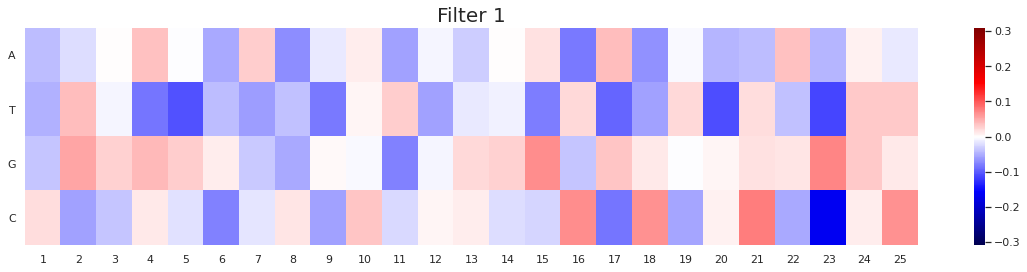

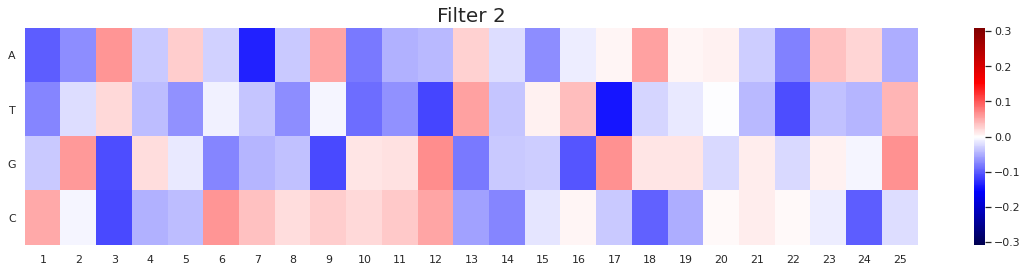

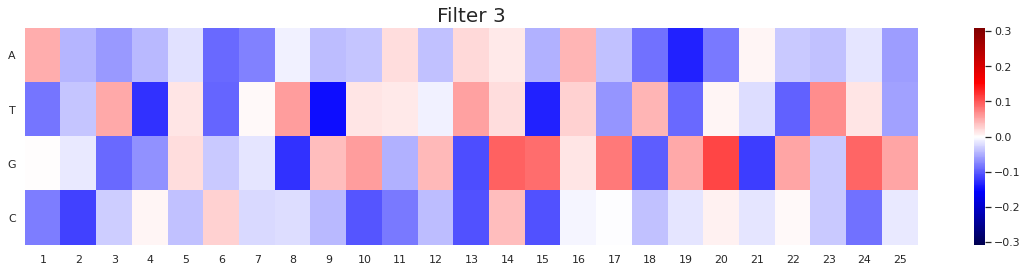

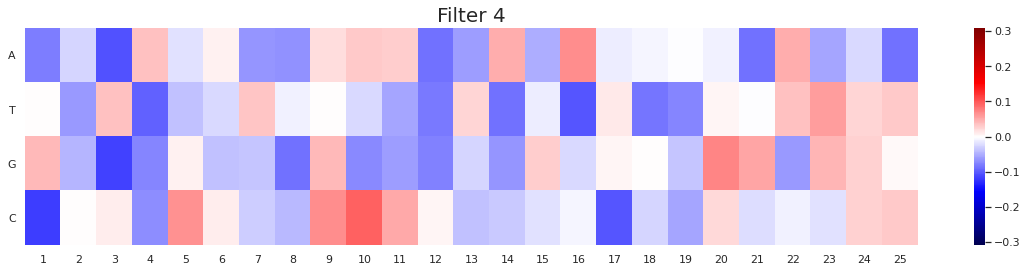

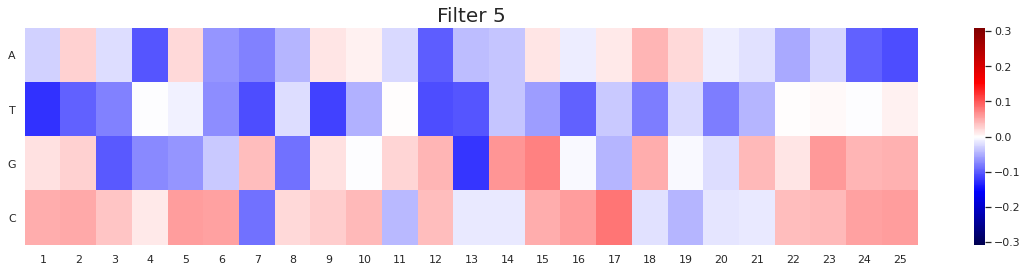

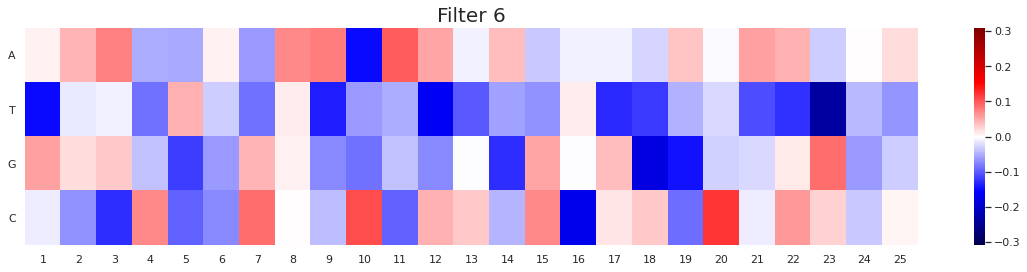

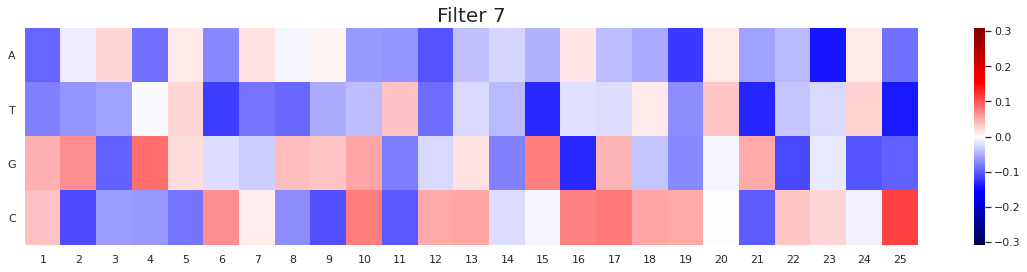

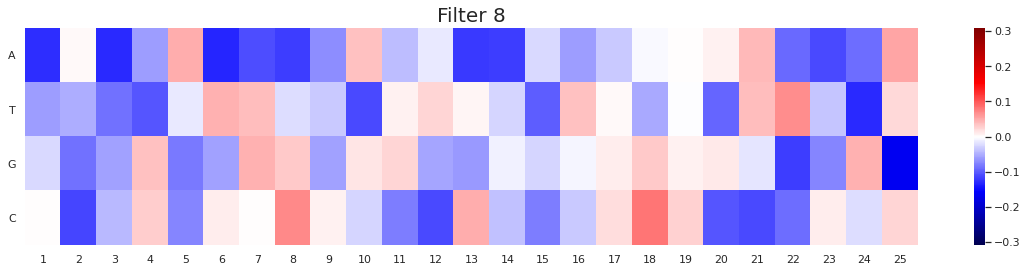

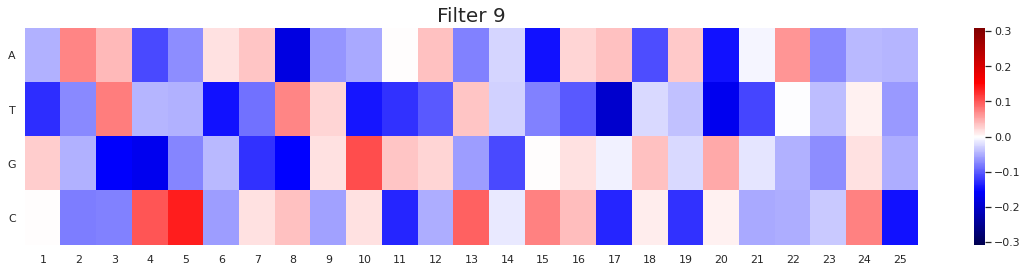

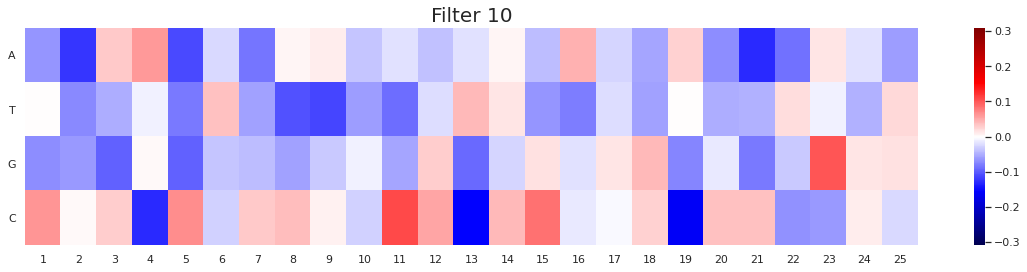

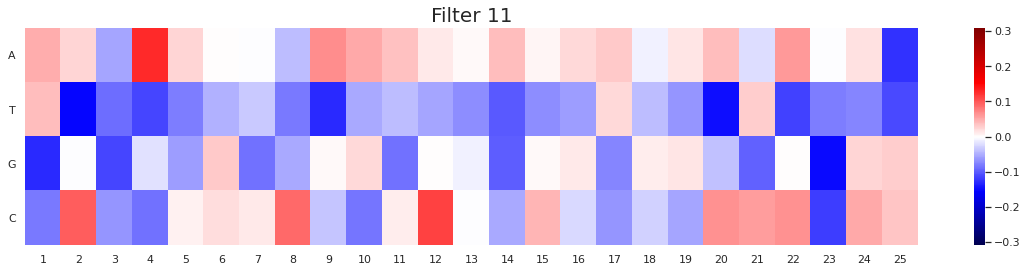

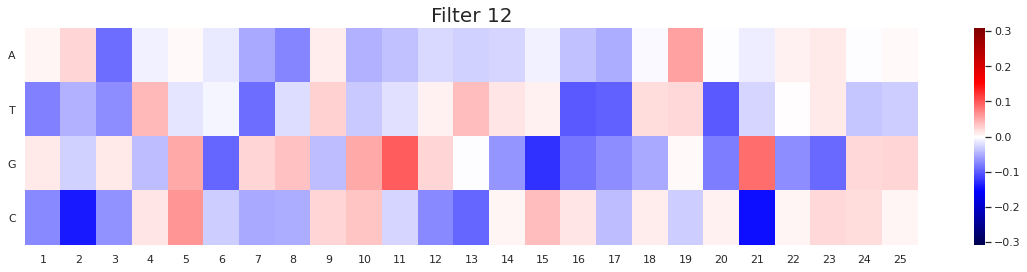

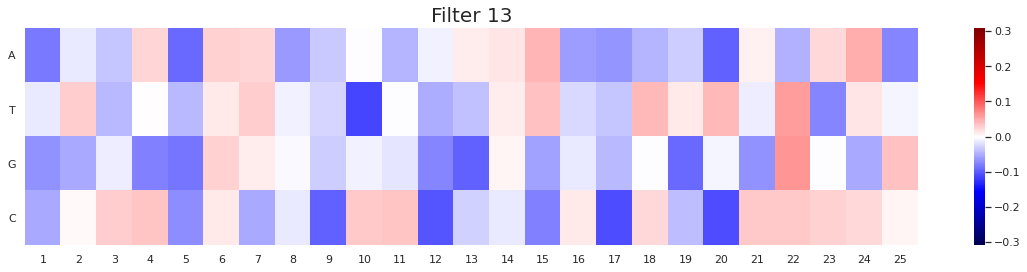

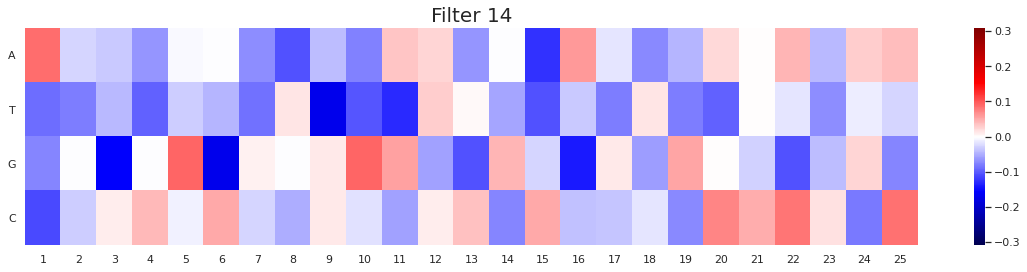

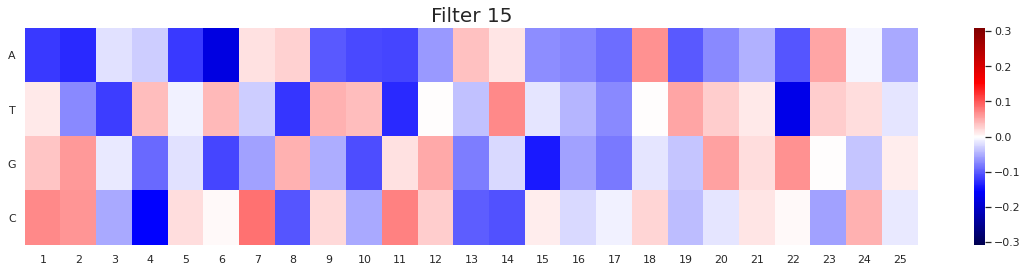

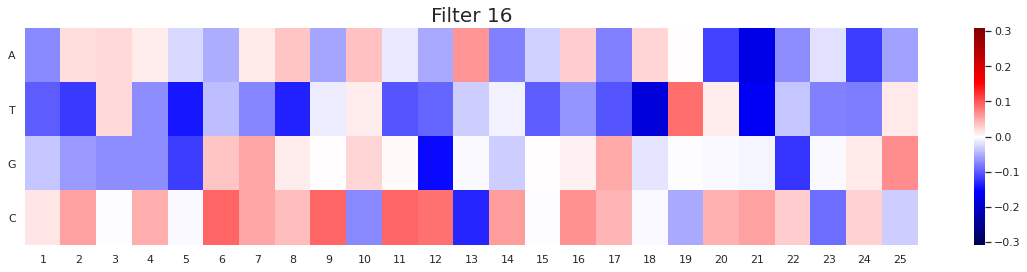

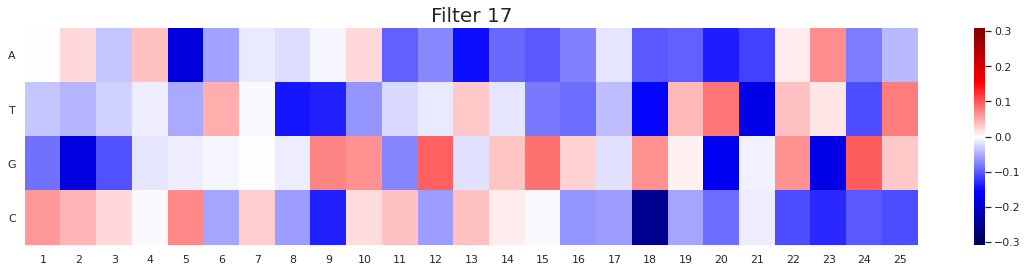

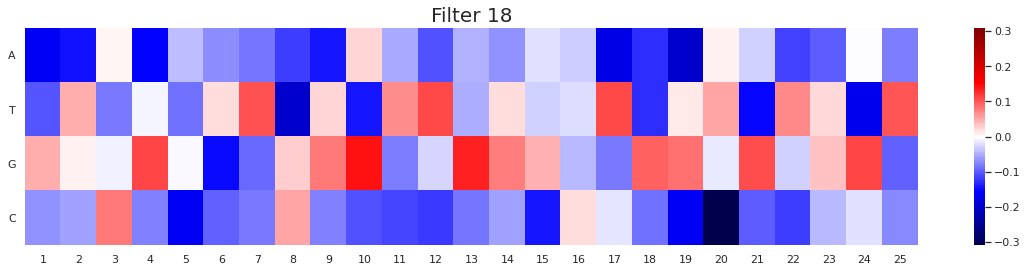

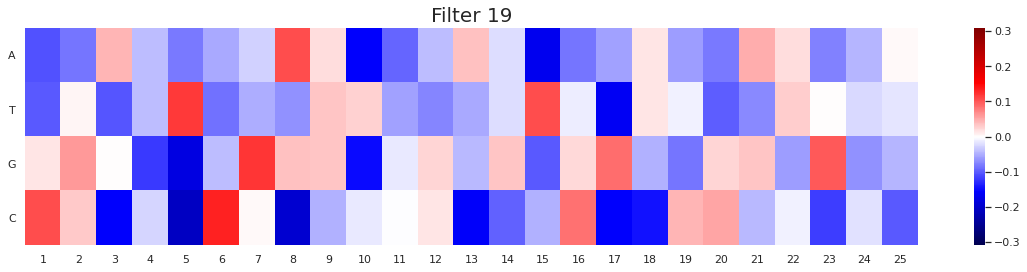

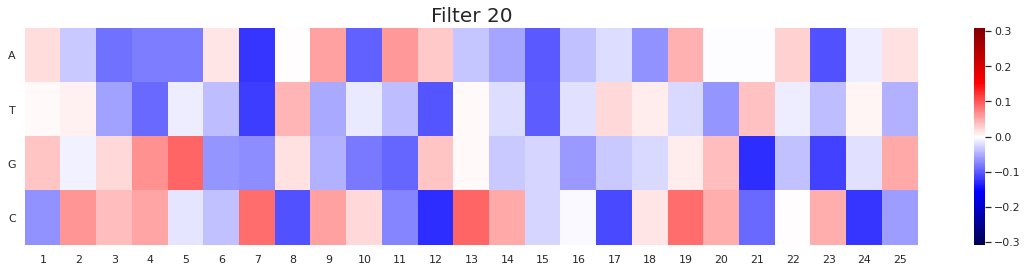

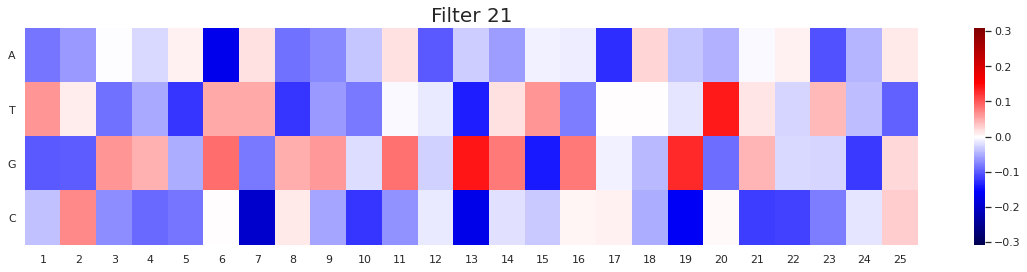

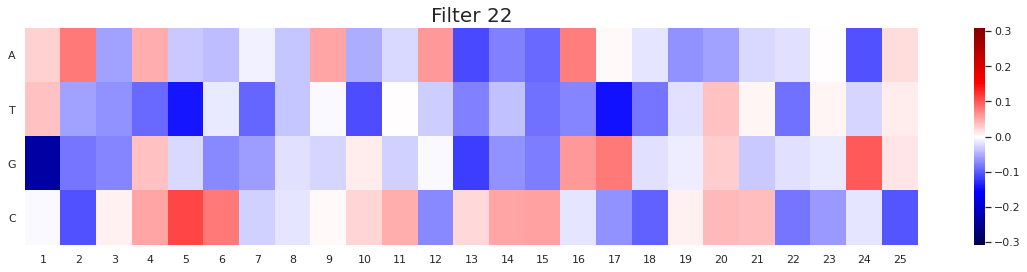

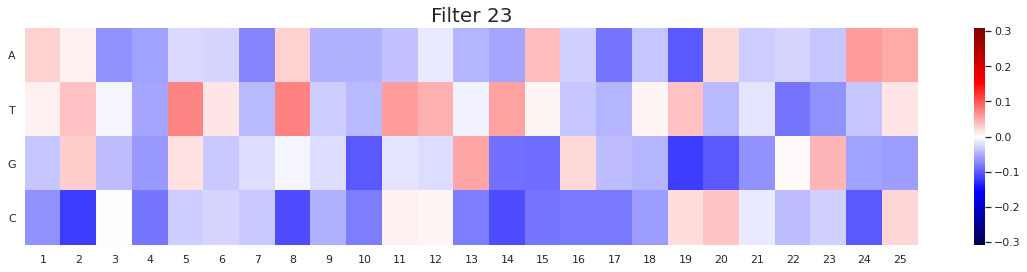

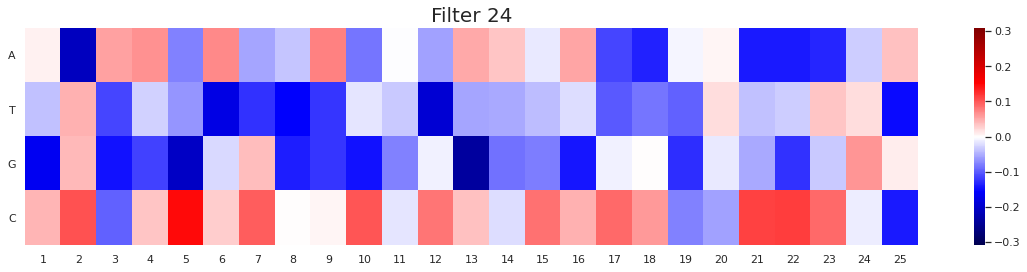

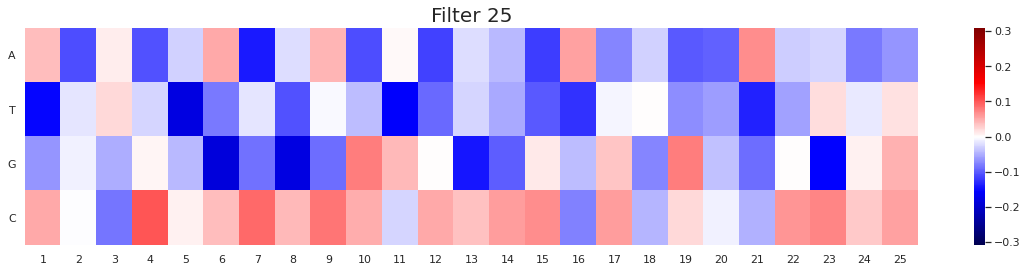

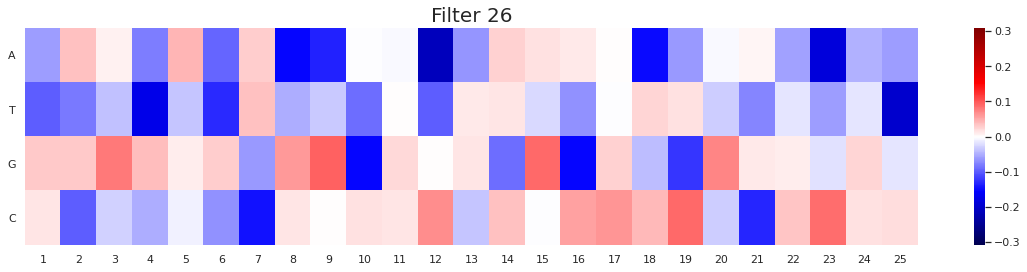

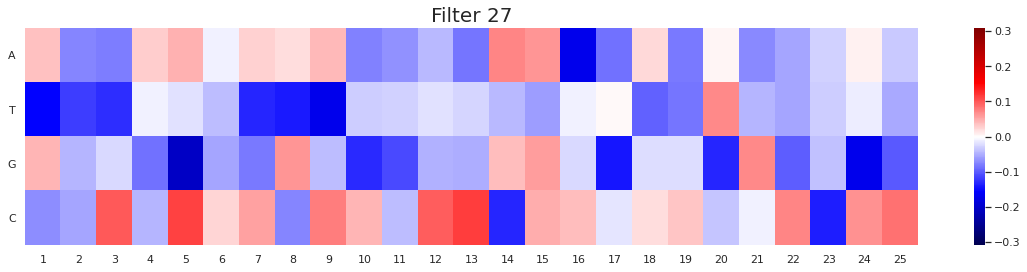

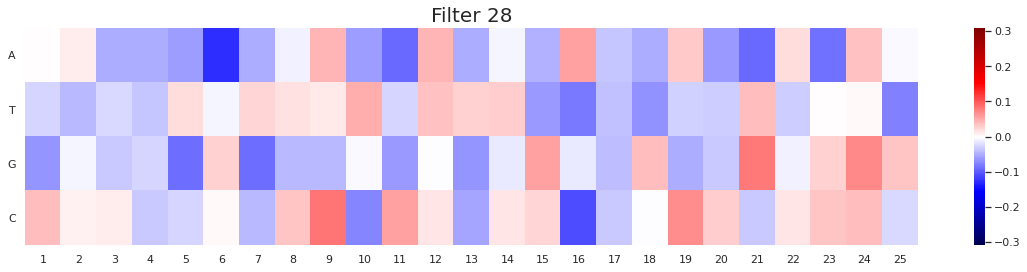

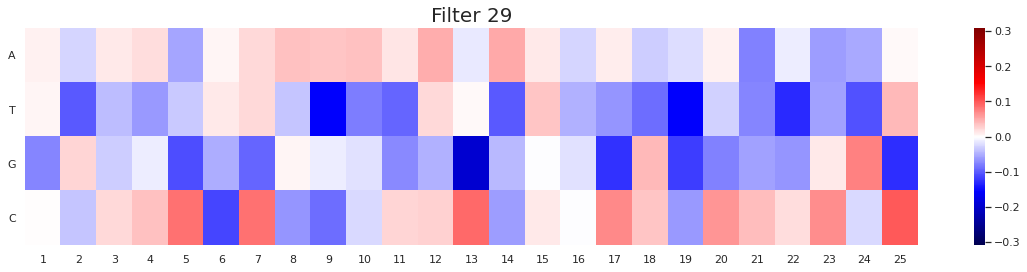

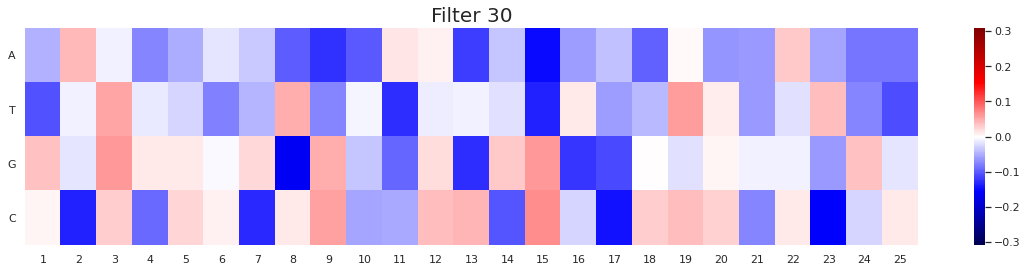

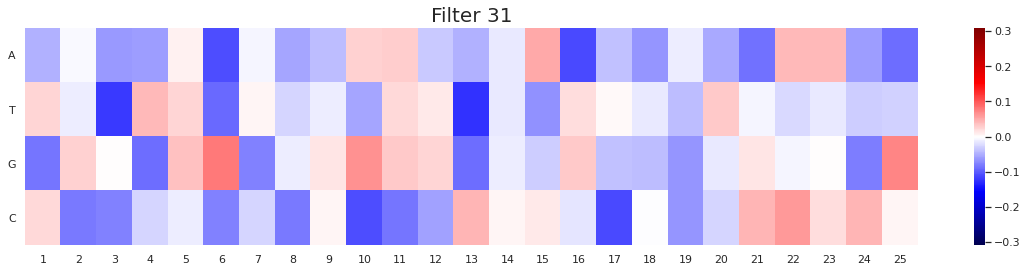

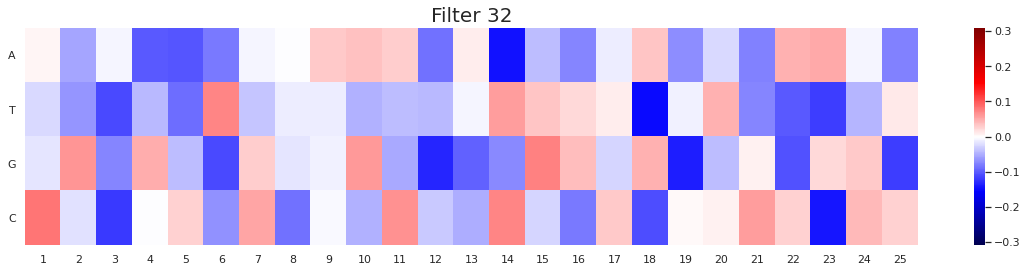

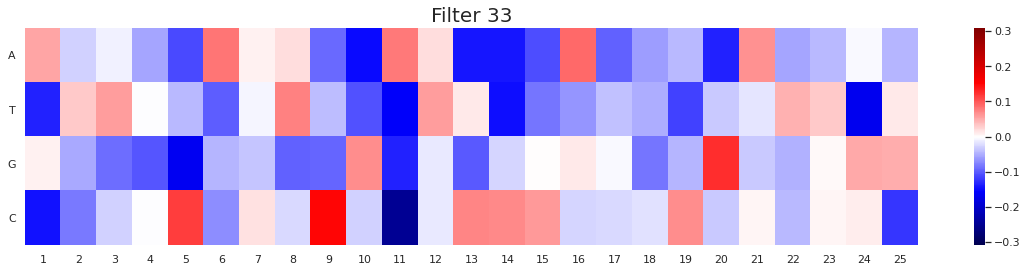

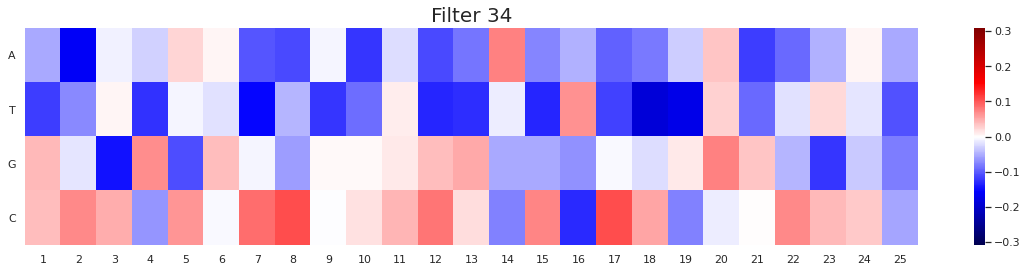

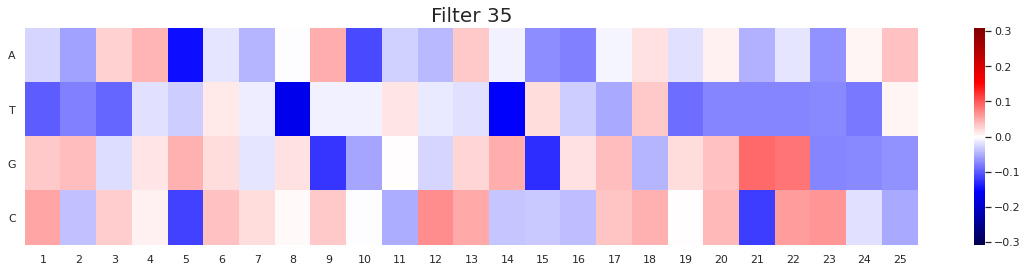

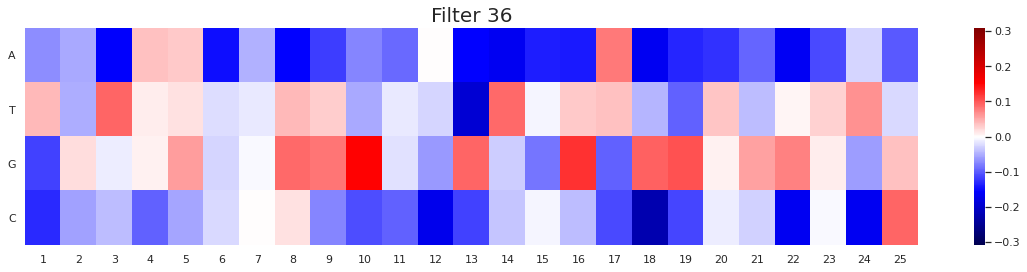

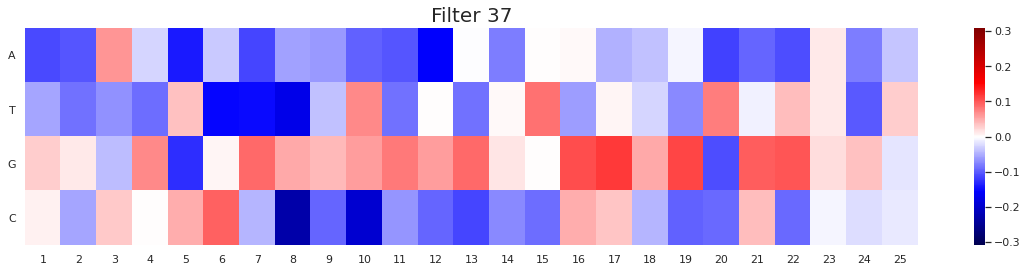

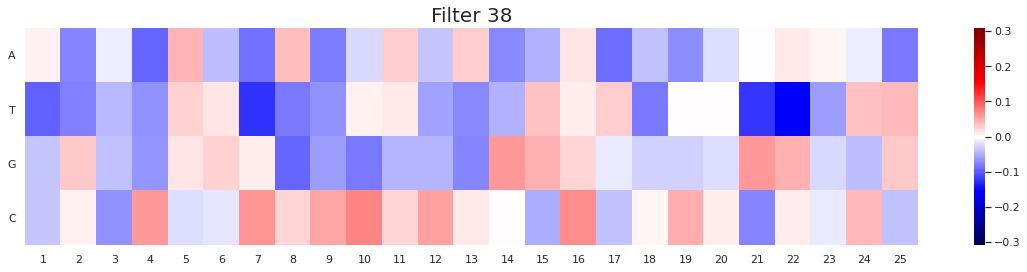

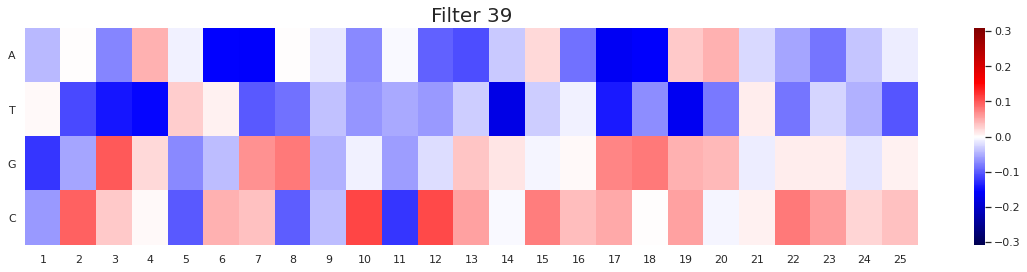

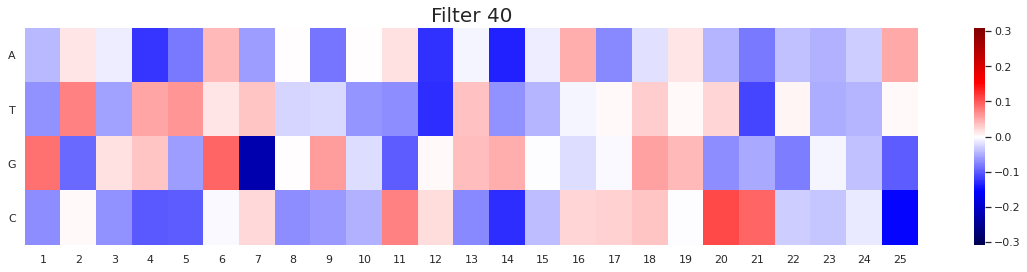

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


counter = 1
for j in range(model.layers[0].weights[0].numpy().shape[2]):
    filter = model.layers[0].weights[0].numpy()[:,:,j]
    plt.figure(figsize=(20, 4))
    ax = sns.heatmap(np.transpose(filter), vmin=-max_abs, vmax=max_abs, center=0, cmap='seismic')
    ax.set_yticklabels(['A', 'T', 'G', 'C'], rotation=0)
    ax.set_xticklabels(np.array(range(len(filter))) + 1, rotation=0)
    ax.set_title('Filter ' + str(counter), fontsize=20)
    plt.show()
    counter += 1

**5.** Сравнение свёрточных сетей с различными параметрами.

In [ ]:
from sklearn.model_selection import KFold

def kfold_testing(X, y, make_model, name):
    
    n_folds = 5
    accuracy = 0
    auc = 0
    loss = 0
    metrics = np.zeros((5))

    kfolds = KFold(n_splits=n_folds, shuffle=True)

    for train, test in kfolds.split(X, y):
        
        model = make_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        s = reset_tf_session()
        INIT_LR = 5e-3
        BATCH_SIZE = 32
        EPOCHS = 30

        bst_model_path = name + '.h5'
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        def lr_scheduler(epoch):
            return INIT_LR * 0.9 ** epoch
    
        model.fit(
            X[train], y[train],
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
            validation_data=(X[test], y[test]),
            shuffle=True,
            verbose=0,
            initial_epoch=0
        )

        model.load_weights(bst_model_path)
        metrics += np.array(model.evaluate(X[test], y[test], verbose=1))
    return np.array(metrics) / n_folds

In [ ]:
convolution_params = [(40, 30), (40, 25), (40, 20), (40, 15), (30, 25), (30, 20), (30, 15), (25, 20), (25, 15), (20, 15)]
pooling_params = [(20, 7), (15, 7)]
dropout_params = [(0.2, 0.1)]

min_loss = 100000
best = []
best_params = []

for conv_filters, conv_size in convolution_params:
    for pool_size, pool_stride in pooling_params:
        local_best = []
        local_min = 100000
        local_params = []
        for dropout1, dropout2 in dropout_params:
            def make_model_CNN():
                model = Sequential()
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size, input_shape=(input_len, 4)))
                model.add(MaxPooling1D(pool_size=pool_size, strides=pool_stride))
                model.add(Dropout(dropout1))
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size))
                model.add(MaxPooling1D(pool_size=pool_size, strides=pool_stride))
                model.add(Dropout(dropout2))
                model.add(Conv1D(filters=conv_filters, kernel_size=conv_size))
                model.add(GlobalMaxPool1D())
                model.add(Dense(1))
                model.add(Activation("sigmoid"))
                
                return model

            print('# of convolution filters: ' + str(conv_filters))
            print('convolution size: ' + str(conv_size))
            print('pool size: ' + str(pool_size))
            print('pool stride: ' + str(pool_stride))
            print('first dropout: ' + str(dropout1))
            print('second dropout: ' + str(dropout2))
            res = kfold_testing(X, y, make_model_CNN, 'CNN')
            print(res)
            if res[0] < min_loss:
                min_loss = res[0]
                best = res
                best_params = [(conv_filters, conv_size), (pool_size, pool_stride), (dropout1, dropout2)]
            if res[0] < local_min:
                local_min = res[0]
                local_best = res
                local_params = [(conv_filters, conv_size), (pool_size, pool_stride), (dropout1, dropout2)]
        print('Local best try:')
        print(local_best)
        print(local_params)

print('Best try:')
print(best)
print(best_params)


# of convolution filters: 40
convolution size: 30
pool size: 20
pool stride: 7
first dropout: 0.2
second dropout: 0.1
[0.5821556925773621, 0.704651153087616, 0.7698734045028687]
Local best try:
[0.5821556925773621, 0.704651153087616, 0.7698734045028687]
[(40, 30), (20, 7), (0.2, 0.1)]
# of convolution filters: 40
convolution size: 30
pool size: 15
pool stride: 7
first dropout: 0.2
second dropout: 0.1
[0.588219964504242, 0.6901162624359131, 0.7664111614227295]
Local best try:
[0.588219964504242, 0.6901162624359131, 0.7664111614227295]
[(40, 30), (15, 7), (0.2, 0.1)]
# of convolution filters: 40
convolution size: 25
pool size: 20
pool stride: 7
first dropout: 0.2
second dropout: 0.1
[0.5735716581344604, 0.707945716381073, 0.775872802734375]
Local best try:
[0.5735716581344604, 0.707945716381073, 0.775872802734375]
[(40, 25), (15, 7), (0.2, 0.1)]
# of convolution filters: 40
convolution size: 20
pool size: 20
pool stride: 7
first dropout: 0.2
second dropout: 0.1
[0.58517427444458, 0.69806

**Обучение реккурентных нейронных сетей:**

**1.** Пример обучения реккурентной модели.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
import tensorflow as tf

for param in [15]:

    def make_model_LSTM():
        model = Sequential()
        model.add(Conv1D(50, kernel_size=35))
        model.add(LeakyReLU())
        model.add(Bidirectional(LSTM(param, input_shape=(input_len, 4))))
        model.add(Dense(5))
        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model
    
    print('# of units: ' + str(param))
    model = make_model_LSTM()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    s = reset_tf_session()
    INIT_LR = 5e-3
    BATCH_SIZE = 32
    EPOCHS = 30

    bst_model_path = 'LSTM' + '.h5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    def lr_scheduler(epoch):
        return INIT_LR * 0.9 ** epoch
    
    model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping, model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
        validation_data=(X_test, y_test),
        shuffle=True,
        verbose=1,
        initial_epoch=0
    )

    model.load_weights(bst_model_path)
    metrics = model.evaluate(X_test, y_test, verbose=0)
    print(metrics)

        

# of units: 15
Epoch 1/30
128/128 [==============================] - 17s 129ms/step - loss: 0.6817 - accuracy: 0.5647 - auc: 0.5865 - val_loss: 0.6852 - val_accuracy: 0.5589 - val_auc: 0.5696 - lr: 0.0050
Epoch 2/30
128/128 [==============================] - 16s 125ms/step - loss: 0.6698 - accuracy: 0.5870 - auc: 0.6235 - val_loss: 0.7081 - val_accuracy: 0.5324 - val_auc: 0.5651 - lr: 0.0045
Epoch 3/30
128/128 [==============================] - 16s 124ms/step - loss: 0.6628 - accuracy: 0.6072 - auc: 0.6421 - val_loss: 0.6894 - val_accuracy: 0.5580 - val_auc: 0.5672 - lr: 0.0041
Epoch 4/30
128/128 [==============================] - 16s 124ms/step - loss: 0.6564 - accuracy: 0.6136 - auc: 0.6551 - val_loss: 0.7030 - val_accuracy: 0.5295 - val_auc: 0.5528 - lr: 0.0036
Epoch 5/30
128/128 [==============================] - 16s 124ms/step - loss: 0.6515 - accuracy: 0.6212 - auc: 0.6630 - val_loss: 0.7116 - val_accuracy: 0.5373 - val_auc: 0.5544 - lr: 0.0033
Epoch 6/30
128/128 [===============